In [50]:
import tensorflow;
import pandas;
from sklearn.model_selection import train_test_split;
from tensorflow import keras;
from tensorflow.keras.models import Sequential;
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt;
from sklearn.decomposition import PCA;
from tensorflow.keras.utils import plot_model;
from tensorflow.keras.regularizers import l2;

In [51]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Import

In [52]:
# Loading data from pre-cleaned csv file
dataframe = pandas.read_csv("/mnt/d/Code/College/Machine Learning/Team Assignment/Default Credit Scoring/credit_card_clients.csv");

## Feature Correlation

In this section I set the treshold with 0.2. Any feature below 0.2 will be discarded.

In [53]:
# Correlation Heatmap
correlation = dataframe.corr();

TRESHOLD = 0;
print("Relationship : Correlation Score");

columns_to_be_dropped = [];
for i in correlation.columns:
    correlation_score = correlation[i]["LABEL"];
    print(i, "-> LABEL : ", correlation_score);

    if(correlation_score < TRESHOLD):
        columns_to_be_dropped.append(i);
        print("Dropping ", i);

dataframe = dataframe.drop(columns=columns_to_be_dropped);

Relationship : Correlation Score
ID -> LABEL :  -0.013951954838986251
Dropping  ID
LIMIT_BAL -> LABEL :  -0.1535198763935072
Dropping  LIMIT_BAL
SEX -> LABEL :  -0.03996057770544172
Dropping  SEX
EDUCATION -> LABEL :  0.028006077656250204
MARRIAGE -> LABEL :  -0.024339215683404438
Dropping  MARRIAGE
AGE -> LABEL :  0.013889834301962887
PAY_0 -> LABEL :  0.32479372847862237
PAY_2 -> LABEL :  0.2635512016721678
PAY_3 -> LABEL :  0.23525251372491712
PAY_4 -> LABEL :  0.21661363684242388
PAY_5 -> LABEL :  0.2041489138761645
PAY_6 -> LABEL :  0.18686636165354611
BILL_AMT1 -> LABEL :  -0.019644197143221562
Dropping  BILL_AMT1
BILL_AMT2 -> LABEL :  -0.014193218088215756
Dropping  BILL_AMT2
BILL_AMT3 -> LABEL :  -0.014075518043214726
Dropping  BILL_AMT3
BILL_AMT4 -> LABEL :  -0.010156495880289674
Dropping  BILL_AMT4
BILL_AMT5 -> LABEL :  -0.006760463841014779
Dropping  BILL_AMT5
BILL_AMT6 -> LABEL :  -0.005372314914815558
Dropping  BILL_AMT6
PAY_AMT1 -> LABEL :  -0.07292948777785163
Dropping  

## Data Pre-Processing
Checkout the `main.ipynb` since I just copy-pasting the whole thing from it.

In [54]:
# Some education data contains 0, 5, and 6. I eliminating "em.

invalid_education_data = [];
for idx, e in enumerate(dataframe['EDUCATION']):
    if(e > 4 or e < 1):
        invalid_education_data.append(idx);

dataframe = dataframe.drop(invalid_education_data);

# Make one hot encoding for Educuation and PAY_0 to 6 since the data is an ordinal data
hot_encoded_education = pandas.get_dummies(dataframe['EDUCATION'], prefix = "education");
hot_encoded_pay_0 = pandas.get_dummies(dataframe['PAY_0'], prefix = "pay_0");
# hot_encoded_pay_1 = pandas.get_dummies(dataframe['PAY_1'], prefix = "pay_1");
hot_encoded_pay_2 = pandas.get_dummies(dataframe['PAY_2'], prefix = "pay_2");
hot_encoded_pay_3 = pandas.get_dummies(dataframe['PAY_3'], prefix = "pay_3");
hot_encoded_pay_4 = pandas.get_dummies(dataframe['PAY_4'], prefix = "pay_4");
hot_encoded_pay_5 = pandas.get_dummies(dataframe['PAY_5'], prefix = "pay_5");
hot_encoded_pay_6 = pandas.get_dummies(dataframe['PAY_6'], prefix = "pay_6");

# Merge the hot_encoded with the main dataframe
for i in [hot_encoded_education, hot_encoded_pay_0, hot_encoded_pay_2, hot_encoded_pay_3, hot_encoded_pay_4, hot_encoded_pay_5, hot_encoded_pay_6]:
    dataframe = pandas.concat([dataframe, i], axis = 1);

print("Data after cleaning: ", dataframe.shape);
print(dataframe.columns.tolist());

Data after cleaning:  (29655, 77)
['EDUCATION', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'LABEL', 'education_1', 'education_2', 'education_3', 'education_4', 'pay_0_-2', 'pay_0_-1', 'pay_0_0', 'pay_0_1', 'pay_0_2', 'pay_0_3', 'pay_0_4', 'pay_0_5', 'pay_0_6', 'pay_0_7', 'pay_0_8', 'pay_2_-2', 'pay_2_-1', 'pay_2_0', 'pay_2_1', 'pay_2_2', 'pay_2_3', 'pay_2_4', 'pay_2_5', 'pay_2_6', 'pay_2_7', 'pay_2_8', 'pay_3_-2', 'pay_3_-1', 'pay_3_0', 'pay_3_1', 'pay_3_2', 'pay_3_3', 'pay_3_4', 'pay_3_5', 'pay_3_6', 'pay_3_7', 'pay_3_8', 'pay_4_-2', 'pay_4_-1', 'pay_4_0', 'pay_4_1', 'pay_4_2', 'pay_4_3', 'pay_4_4', 'pay_4_5', 'pay_4_6', 'pay_4_7', 'pay_4_8', 'pay_5_-2', 'pay_5_-1', 'pay_5_0', 'pay_5_2', 'pay_5_3', 'pay_5_4', 'pay_5_5', 'pay_5_6', 'pay_5_7', 'pay_5_8', 'pay_6_-2', 'pay_6_-1', 'pay_6_0', 'pay_6_2', 'pay_6_3', 'pay_6_4', 'pay_6_5', 'pay_6_6', 'pay_6_7', 'pay_6_8']


In [55]:
# Define label data
label = dataframe['LABEL'];

# Drop ID, SEX, EDUCATION, MARRIAGE, and LABEL from dataframe for features
features = dataframe.drop(columns=["EDUCATION", 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', "LABEL"]);

# Typecasting all values within to int64 because ANN need to be standardized

for i in dataframe.columns:
    dataframe[i] = dataframe[i].astype(int);

# Split the data into training, validation, and testing sets
feature_train, feature_test, label_train, label_test = train_test_split(features, label, test_size = 0.6, random_state = 42);
feature_validation, feature_test, label_validation, label_test = train_test_split(feature_test, label_test, test_size=0.5, random_state = 20);

# Scale the features
scaler = StandardScaler();
feature_train_scaled = scaler.fit_transform(feature_train);
feature_validation_scaled = scaler.fit_transform(feature_validation);
feature_test_scaled = scaler.transform(feature_test);

## Fine Tunning

This code based on Tensorflow Artifical Neural Network.

Epoch 1/70


2024-01-16 15:58:32.396573: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-01-16 15:58:32.443140: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-01-16 15:58:32.488653: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-01-16 15:58:32.535920: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

371/371 [==============================] - 4s 8ms/step - loss: 0.5366 - accuracy: 0.7694 - val_loss: 0.5294 - val_accuracy: 0.7781
Epoch 2/70
371/371 [==============================] - 3s 8ms/step - loss: 0.5278 - accuracy: 0.7795 - val_loss: 0.5289 - val_accuracy: 0.7781
Epoch 3/70
371/371 [==============================] - 3s 8ms/step - loss: 0.4852 - accuracy: 0.7833 - val_loss: 0.4533 - val_accuracy: 0.8041
Epoch 4/70
371/371 [==============================] - 3s 8ms/step - loss: 0.4470 - accuracy: 0.8123 - val_loss: 0.4496 - val_accuracy: 0.8123
Epoch 5/70
371/371 [==============================] - 3s 7ms/step - loss: 0.4421 - accuracy: 0.8190 - val_loss: 0.4474 - val_accuracy: 0.8210
Epoch 6/70
371/371 [==============================] - 3s 7ms/step - loss: 0.4397 - accuracy: 0.8222 - val_loss: 0.4417 - val_accuracy: 0.8209
Epoch 7/70
371/371 [==============================] - 3s 7ms/step - loss: 0.4385 - accuracy: 0.8241 - val_loss: 0.4428 - val_accuracy: 0.8222
Epoch 8/70
371/37

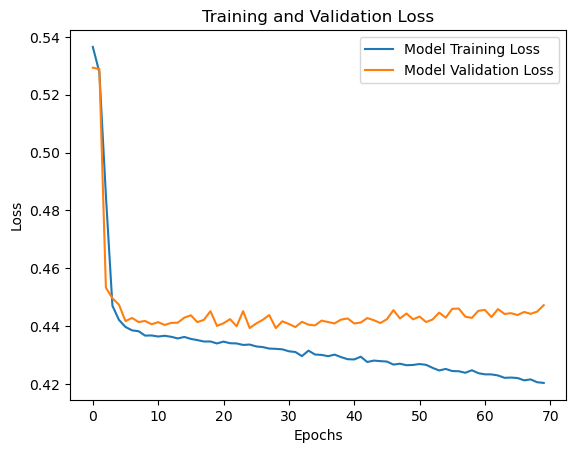

279/279 [==============================] - 1s 3ms/step - loss: 0.4502 - accuracy: 0.8159
Loss:  0.45019081234931946  Accuracy:  0.8158929944038391


In [56]:
class ANNModel:

    optimizer = "adam";

    def input_layer(self):
        return keras.layers.Dense(32, input_dim = 69, activation = "sigmoid"); # 11 is total features dimension

    def hidden_layer(self):
        return [
            keras.layers.Dense(256, activation = "sigmoid"),
            keras.layers.Dense(128, activation = "hard_sigmoid"),
        ];

    def shallow_hidden_layer(self):
        return [
            keras.layers.Dense(32, activation = "hard_sigmoid"),
            keras.layers.Dense(16, activation = "sigmoid"),
            keras.layers.Dense(8, activation = "sigmoid"),
        ];

    def output_layer(self):
        return keras.layers.Dense(1, activation = "sigmoid"); # Since output is only 1 label.

    def fit(self):
        model = Sequential();
        model.add(self.input_layer());

        for i in [self.hidden_layer(), self.shallow_hidden_layer(), self.hidden_layer(), self.hidden_layer()]:
            for j in i:
                model.add(j);

        model.add(self.output_layer());

        plot_model(model, to_file="model_architecture.png", show_shapes=True)

        model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]);

        model_plot = model.fit(feature_train_scaled, label_train, epochs = 70, validation_data=(feature_validation_scaled, label_validation));

        plt.plot(model_plot.history["loss"], label = "Model Training Loss");
        plt.plot(model_plot.history["val_loss"], label = "Model Validation Loss");
        plt.title("Training and Validation Loss");
        plt.xlabel("Epochs");
        plt.ylabel("Loss");
        plt.legend();
        plt.show();

        return model;

dojo = ANNModel();
model = dojo.fit();

loss, accuracy = model.evaluate(feature_test_scaled, label_test);
print("Loss: ", loss, " Accuracy: ", accuracy);